In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from scipy import stats 
import matplotlib.font_manager as fm
from sklearn.ensemble import RandomForestClassifier
# NoteBook 안에 그래프를 위해(?)
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')


#  그래프에서 격자로 숫자 범위가 잘 띄게
plt.style.use('ggplot')

In [2]:
#  parse_dates 를 datetime 으로 하면 datetime 식으로 불러온다... 아직 무슨말인지 잘 모르겠음
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])


# Feature Engineering

In [3]:
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour
train['minute']=train['datetime'].dt.minute
train['second']=train['datetime'].dt.second
train['dayofweek']=train['datetime'].dt.dayofweek
train.shape


(10886, 19)

In [4]:
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['day']=test['datetime'].dt.day
test['hour']=test['datetime'].dt.hour
test['minute']=test['datetime'].dt.minute
test['second']=test['datetime'].dt.second
test['dayofweek']=test['datetime'].dt.dayofweek
test.shape

(6493, 16)

* 풍속 data 시각화

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

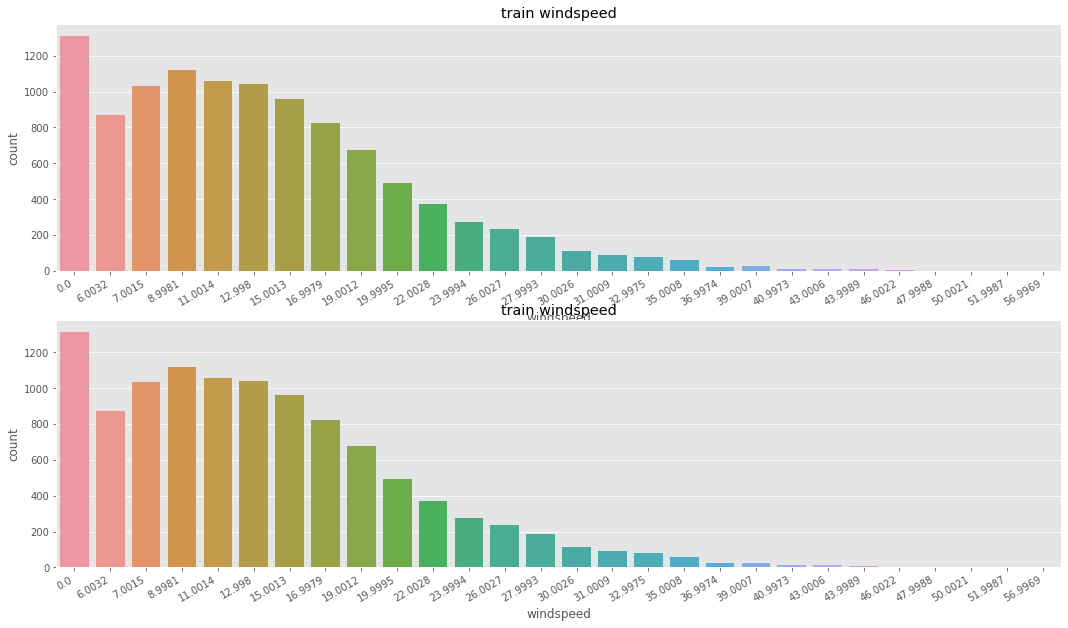

In [5]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count',title='train windspeed')
sns.countplot(data=train,x='windspeed',ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30,ha='right')
axes[1].set(ylabel='Count',title='train windspeed')
sns.countplot(data=train,x='windspeed',ax=axes[1])


* 확인결과 측정하지 않은 값을 모두 0으로 넣어주었다고 판단 됨.
* 따라서 해당 데이터를 평균값을 넣는 방법도 있지만, 머신러닝을 통해 예측하여 풍속을 넣어주고자 함.


In [6]:
def predict_windspeed(data):
    # 풍속이 0인것과 아닌것 구분
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]

    # 풍속 예측을 위해 사용될 피쳐 선택
    wCol = ['season','weather','humidity','month','temp','year','atemp']

    # 풍속이 0이 아닌 타입을 str로 바꾸기
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처값을 바탕으로 풍속 학습
    rfModel_wind.fit(dataWindNot0[wCol],dataWindNot0['windspeed'])

    # 학습값 바탕으로 풍속 0 의 풍속값 예측
    wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

    # 값 예측 후 비교위해 예측값을 넣어 줄 데이터 프레임 새로 짜기
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측값 넣어주기
    predictWind0['windspeed'] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터 프레임에 예측값 프레임을 합치기
    data = predictWindNot0.append(predictWind0)

    data['windspeed'] = data['windspeed'].astype(float)

    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)

    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

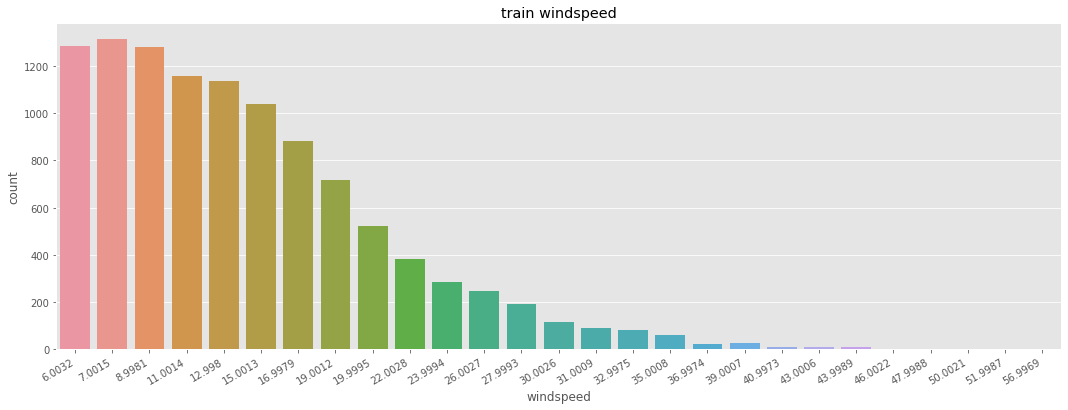

In [7]:
# 0 값 조정.
train = predict_windspeed(train)

fig , axl = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(axl)
plt.xticks(rotation=30,ha='right')
axl.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train, x= 'windspeed',ax=axl)